# 🩺Diabetes Prediction from Early Symptoms

This is a self-driven project where I used early symptom data to predict the likelihood of diabetes using machine learning. The idea was to simulate a real-world healthcare use case: can we help screen people for diabetes without lab results, just based on what they feel?

As someone who's passionate about both data and healthcare, I wanted this project to blend technical modeling with meaningful insights.


In [1]:
#1. Import libraries and packages

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, roc_auc_score, roc_curve

sns.set(style="whitegrid")


In [2]:
#2. Import dataset
from google.colab import drive
drive.mount('/content/drive') # Mount Google Drive to access files
df = pd.read_csv('/content/drive/My Drive/Portfolio/diabetes_data_upload.csv')

Mounted at /content/drive


In [3]:
#3. Exploration Data Analysis (EDA)

#3a. Summarizing data using Descriptive Statistics

print("Dataset Overview:")
print(df.head())

print("\nDataset Info:")
print(df.info())

print("\nMissing Values:")
print(df.isnull().sum())

print("\nClass Distribution:")
print(df['class'].value_counts())

Dataset Overview:
   Age Gender Polyuria Polydipsia sudden weight loss weakness Polyphagia  \
0   40   Male       No        Yes                 No      Yes         No   
1   58   Male       No         No                 No      Yes         No   
2   41   Male      Yes         No                 No      Yes        Yes   
3   45   Male       No         No                Yes      Yes        Yes   
4   60   Male      Yes        Yes                Yes      Yes        Yes   

  Genital thrush visual blurring Itching Irritability delayed healing  \
0             No              No     Yes           No             Yes   
1             No             Yes      No           No              No   
2             No              No     Yes           No             Yes   
3            Yes              No     Yes           No             Yes   
4             No             Yes     Yes          Yes             Yes   

  partial paresis muscle stiffness Alopecia Obesity     class  
0              No     

# 📂 Dataset

Let's understand what data we're working with.

- The dataset has 520 rows (patients) and 17 columns (symptoms + gender + age + diabetes result).
- Most features are **binary** (Yes/No), like "Polyuria" (frequent urination) or "Itching."
- The target variable is `class`, which tells us if the patient is diabetic (Positive) or not (Negative).

This structure looks beginner-friendly — simple, clean, and perfect for building early machine learning intuition.


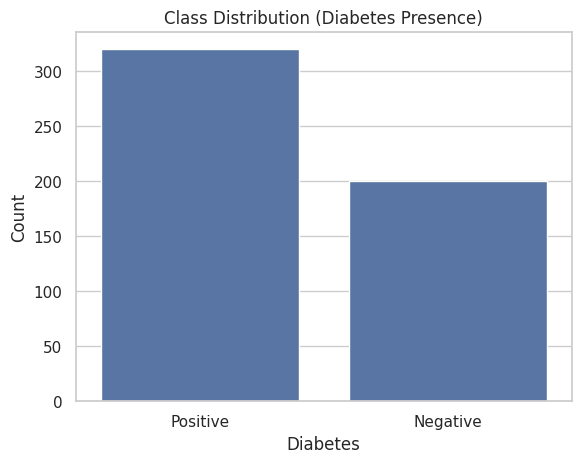

In [4]:
#3b. Visualizing Data Distributions
#Visualize Class Distributions

sns.countplot(x='class', data=df)
plt.title("Class Distribution (Diabetes Presence)")
plt.xlabel("Diabetes")
plt.ylabel("Count")
plt.show()

Looks like there's some imbalance on the dataset, more positive cases thatn negative. Might consider to treat this imbalance for modeling later.

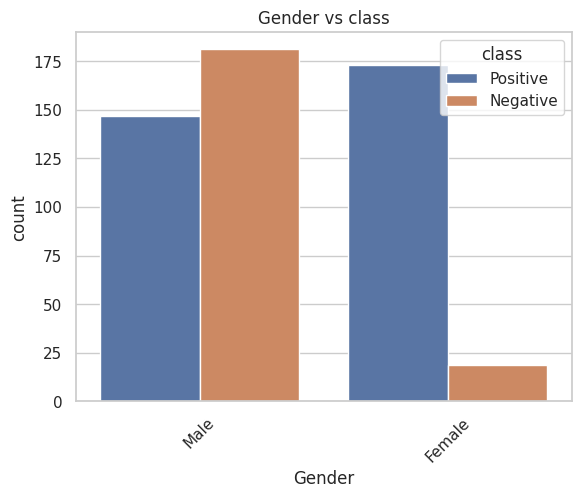

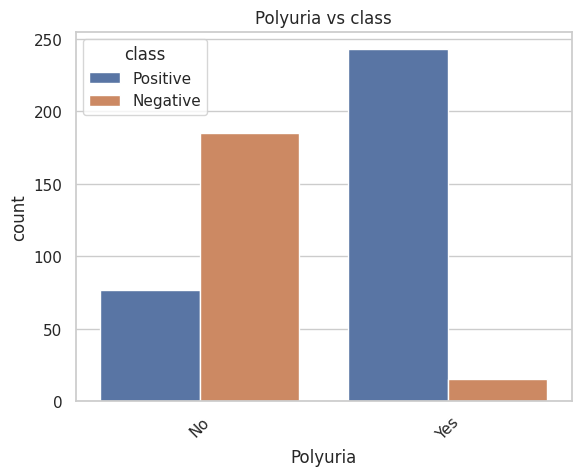

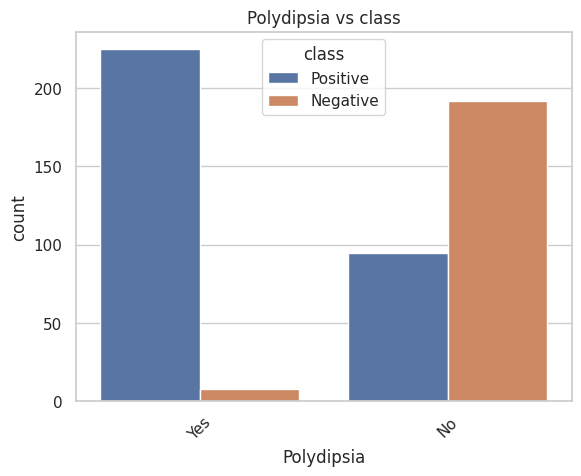

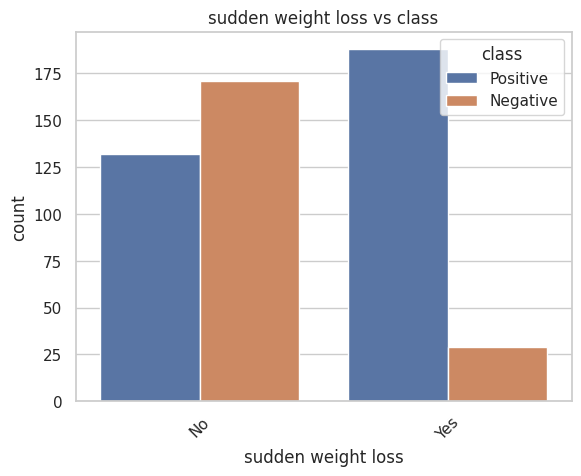

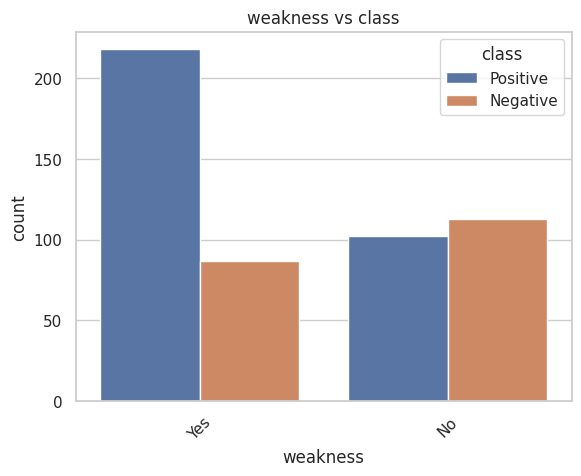

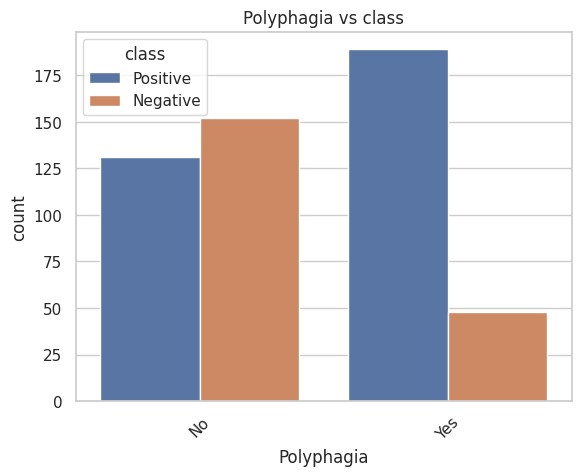

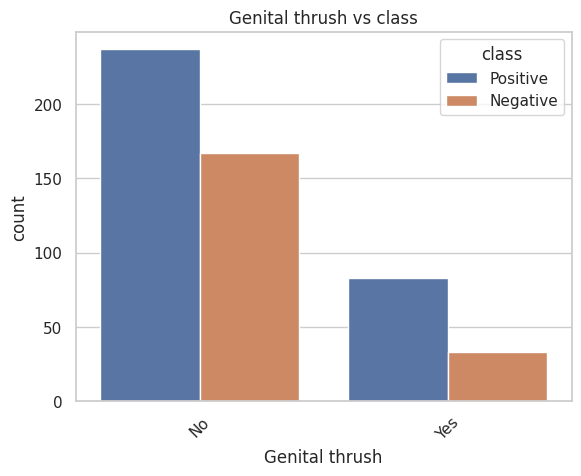

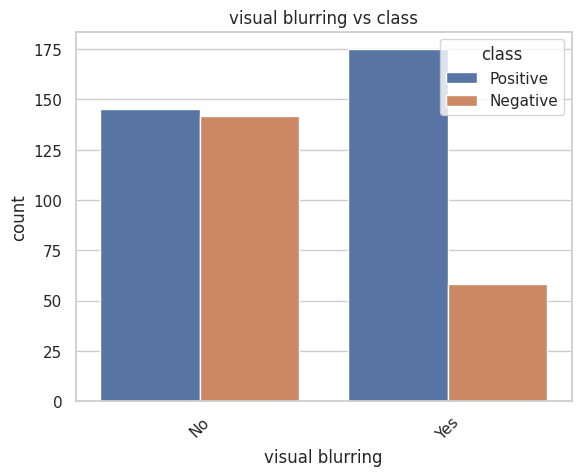

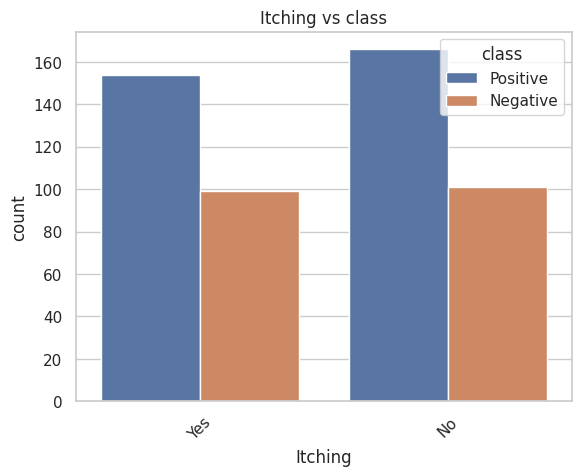

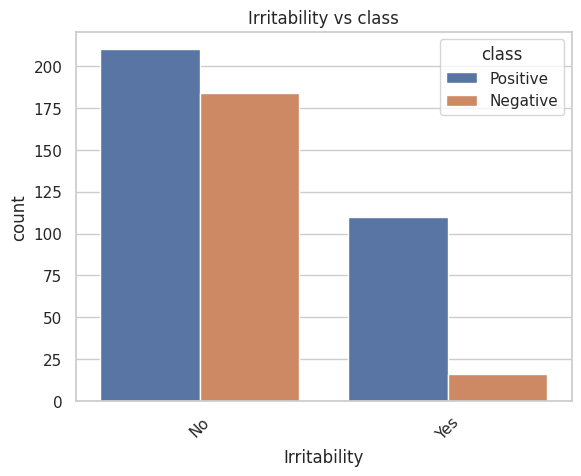

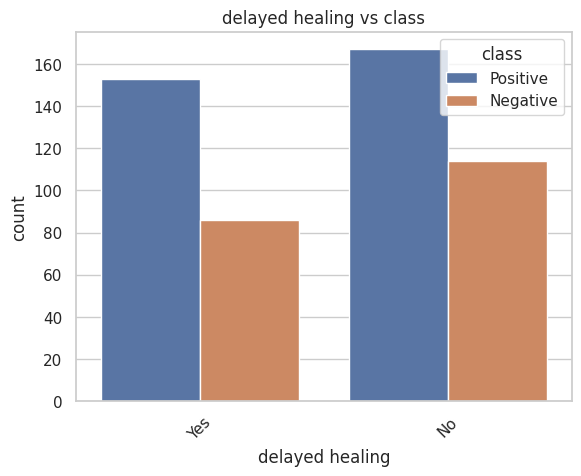

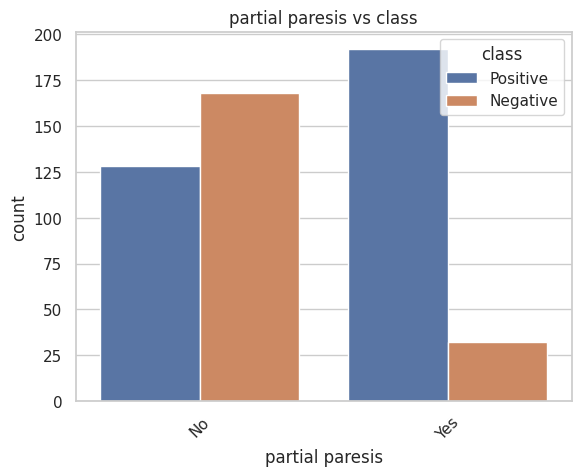

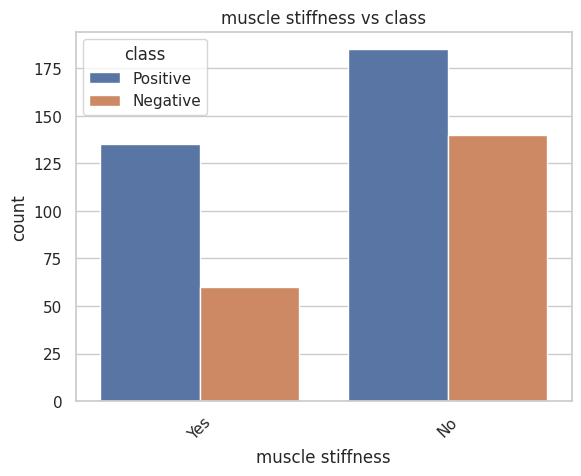

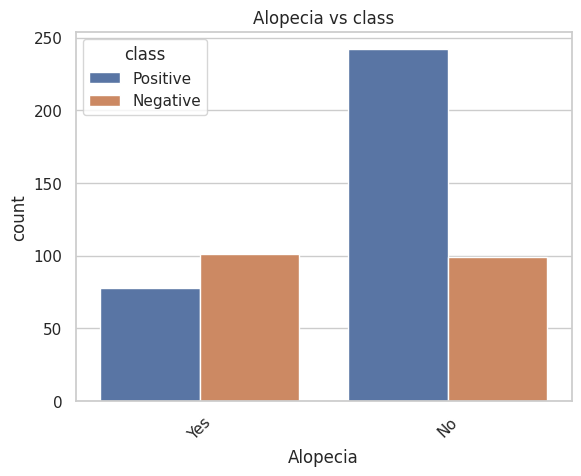

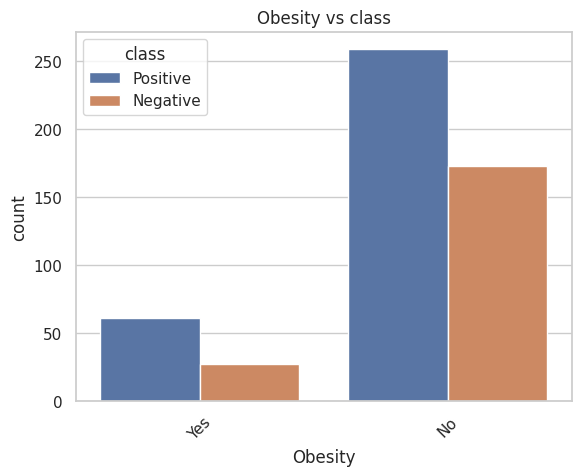

In [5]:
#Visualize all feature distributions
def plot_binary_features(df, features, target='class'):
    for col in features:
        if df[col].nunique() == 2:
            sns.countplot(x=col, hue=target, data=df)
            plt.title(f"{col} vs {target}")
            plt.xticks(rotation=45)
            plt.show()

# list of columns to plot (excluding 'Age' and 'class')
binary_cols = df.columns.drop(['Age', 'class'])
plot_binary_features(df, binary_cols)


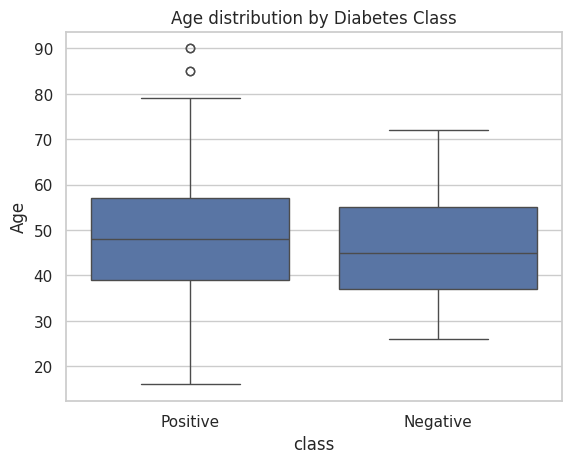

          count       mean        std   min   25%   50%   75%   max
class                                                              
Negative  200.0  46.360000  12.080983  26.0  37.0  45.0  55.0  72.0
Positive  320.0  49.071875  12.097481  16.0  39.0  48.0  57.0  90.0


In [6]:
#Visualize any possible correlation
sns.boxplot(x='class', y='Age', data=df)
plt.title("Age distribution by Diabetes Class")
plt.show()

print(df.groupby('class')['Age'].describe())


# 🔍 Exploratory Data Analysis (EDA)

Before building any model, it's really important to **know your data**.

Here’s what I explored:
- **Polyuria** and **Polydipsia** seem to have a strong relationship with diabetes.
- **Age** seems to matter too — diabetic patients are slightly older on average.
- There’s a small class imbalance (more Positive than Negative), but not too extreme.
- No missing data — lucky! Saves me preprocessing work.

📌 EDA helped me form an intuition:  
If someone reports Polyuria, Polydipsia, and is a bit older, they might have a higher chance of having diabetes.


# 🧼 Data Preprocessing

To prepare the data for modeling, here’s what I did step-by-step:

- **Convert Yes/No** into **1/0**: Machine learning models don't understand words — they need numbers.
- **Encode Gender**: Male becomes 1, Female becomes 0.
- **Split into training and testing sets**: 80% for training the model, 20% for testing how well it performs.
- **Stratify**: So that both train and test have a balanced number of diabetics and non-diabetics.

Because most features are already binary, I **didn't need to scale** the features.  
(Scaling matters more for models that use distances like KNN, or continuous numeric features.)

✅ Now my data is clean, numeric, and ready for machine learning!


In [7]:
#4. Data Processing

#Standardize column names
df.columns = df.columns.str.strip().str.lower().str.replace(" ", "_")

In [8]:
#Convert yes/ no to 1/0
df = df.replace({'Yes': 1, 'No': 0})

<ipython-input-8-8edc869b5e50>:2: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df = df.replace({'Yes': 1, 'No': 0})


In [9]:
#Encode the target variable
df['class'] = df['class'].map({'Positive': 1, 'Negative': 0})

In [10]:
#Convert Gender to Binary
df['gender'] = df['gender'].map({'Male': 1, 'Female': 0})

In [11]:
#Split Features & target
X = df.drop('class', axis=1)
y = df['class']

In [12]:
#Train-Test Split
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# 🧠 Handling Class Imbalance

Although the dataset shows a slight class imbalance (more diabetics than non-diabetics), it was not extreme enough to require synthetic oversampling techniques like **SMOTE**.

Instead, I used the **`class_weight='balanced'`** parameter when training Logistic Regression and Random Forest models.

This automatically adjusts the weights inversely proportional to class frequencies, helping the model not to favor the majority class while training.


# 🤖 Modeling

Now comes the fun part: building and comparing models!

I didn't want to just throw fancy models immediately — I wanted to **build understanding** step-by-step.

---
## 1️⃣ Logistic Regression

First, I trained a **Logistic Regression** model.

Why?  
Because Logistic Regression is:
- Simple
- Interpretable
- A great "baseline" model to beat

In [13]:
#1. Train the model
from sklearn.linear_model import LogisticRegression

# Initialize model
logreg = LogisticRegression(class_weight='balanced', max_iter=1000, random_state=42)

# Fit the model
logreg.fit(X_train, y_train)


LogisticRegression(class_weight='balanced', max_iter=1000, random_state=42)

We use class_weight='balanced' to handle the slightly imbalanced target variable.

In [14]:
#2. Make predictions
y_pred = logreg.predict(X_test)

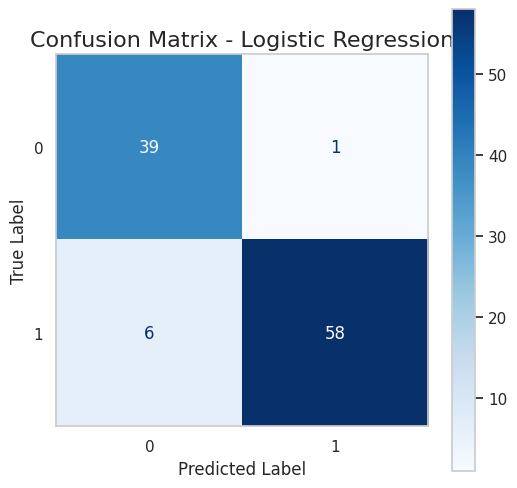

              precision    recall  f1-score   support

           0       0.87      0.97      0.92        40
           1       0.98      0.91      0.94        64

    accuracy                           0.93       104
   macro avg       0.92      0.94      0.93       104
weighted avg       0.94      0.93      0.93       104



In [29]:
# 3. Evaluate the model

from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)

fig, ax = plt.subplots(figsize=(6, 6))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=np.unique(y_test))
disp.plot(
    cmap="Blues",
    colorbar=True,
    ax=ax,
    values_format='d'
)
plt.title("Confusion Matrix - Logistic Regression", fontsize=16)
plt.xlabel("Predicted Label", fontsize=12)
plt.ylabel("True Label", fontsize=12)
plt.grid(False)
plt.show()

# Classification Report
print(classification_report(y_test, y_pred))


True Positives (TP): 58 people with diabetes correctly predicted

True Negatives (TN): 39 people without diabetes correctly predicted

False Positives (FP): 1 person wrongly predicted as diabetic

False Negatives (FN): 6 people with diabetes missed by the model



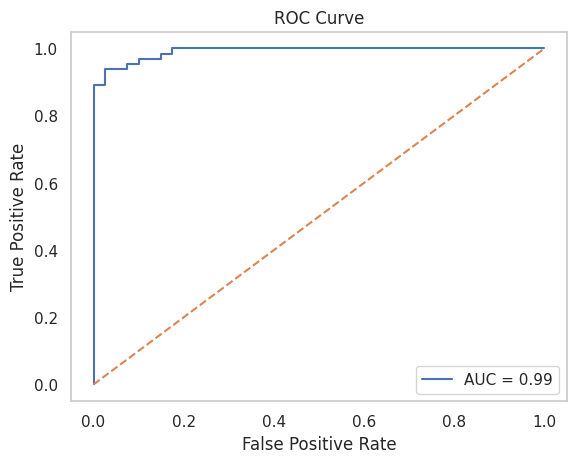

In [16]:
#4. Get probabilities + ROC Curve
from sklearn.metrics import roc_auc_score, roc_curve

# Get probability scores
y_proba = logreg.predict_proba(X_test)[:,1]

# ROC Curve
fpr, tpr, thresholds = roc_curve(y_test, y_proba)
plt.plot(fpr, tpr, label=f'AUC = {roc_auc_score(y_test, y_proba):.2f}')
plt.plot([0, 1], [0, 1], linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.grid()
plt.show()


📈 Results:
- **Accuracy**: 93%
- **Recall**: 91% (caught 91% of real diabetic patients)
- **AUC**: 0.99

Not bad for a simple model!  
But I wanted to see if I could push the performance even higher.

## 2️⃣ Random Forest

Next, I tried **Random Forest** — a much stronger, flexible model.

Random Forest is great because:
- It builds **lots of small decision trees** and averages them
- It’s **robust to overfitting** (especially with small datasets)
- It tells us **feature importance** (which symptoms matter most)

In [17]:
#1. Train the model

from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(random_state=42, class_weight='balanced', n_estimators=100)
rf.fit(X_train, y_train)


RandomForestClassifier(class_weight='balanced', random_state=42)

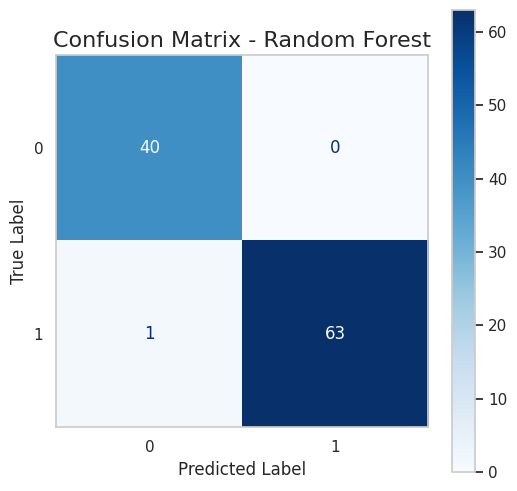

              precision    recall  f1-score   support

           0       0.98      1.00      0.99        40
           1       1.00      0.98      0.99        64

    accuracy                           0.99       104
   macro avg       0.99      0.99      0.99       104
weighted avg       0.99      0.99      0.99       104



In [18]:
# 2. Predict and evaluate
y_pred_rf = rf.predict(X_test)

from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Confusion Matrix
cm_rf = confusion_matrix(y_test, y_pred_rf)

fig, ax = plt.subplots(figsize=(6, 6))
disp = ConfusionMatrixDisplay(confusion_matrix=cm_rf, display_labels=rf.classes_)
disp.plot(
    cmap="Blues",
    colorbar=True,
    ax=ax,
    values_format='d'
)
plt.title("Confusion Matrix - Random Forest", fontsize=16)
plt.xlabel("Predicted Label", fontsize=12)
plt.ylabel("True Label", fontsize=12)
plt.grid(False)
plt.show()

# Classification Report
print(classification_report(y_test, y_pred_rf))


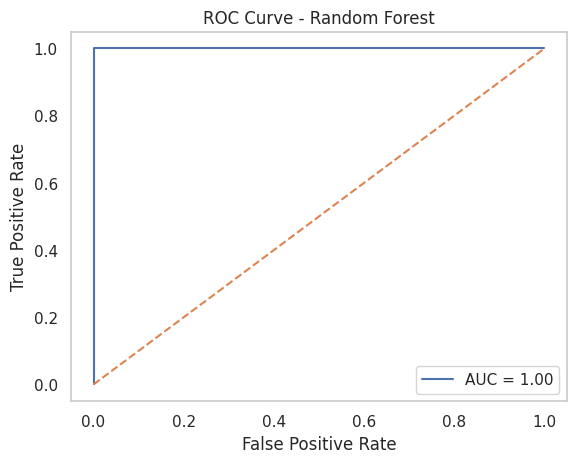

In [19]:
#3. ROC Curve
from sklearn.metrics import roc_curve, roc_auc_score

y_proba_rf = rf.predict_proba(X_test)[:,1]

fpr, tpr, thresholds = roc_curve(y_test, y_proba_rf)
plt.plot(fpr, tpr, label=f"AUC = {roc_auc_score(y_test, y_proba_rf):.2f}")
plt.plot([0,1], [0,1], linestyle='--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve - Random Forest")
plt.legend()
plt.grid()
plt.show()


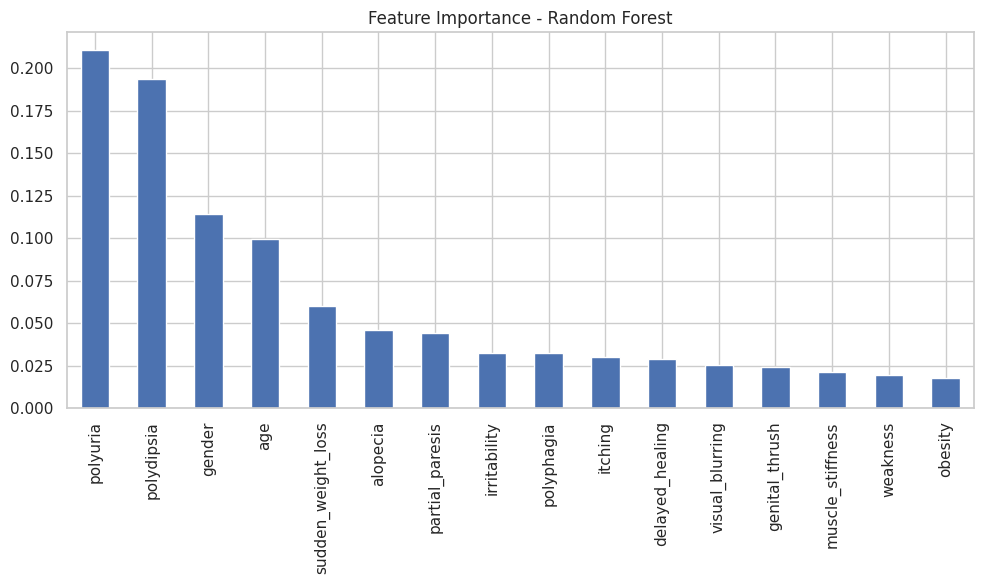

In [20]:
#4. Feature Importance
importances = rf.feature_importances_
features = X.columns

# Plot
feat_importance = pd.Series(importances, index=features).sort_values(ascending=False)
feat_importance.plot(kind='bar', figsize=(10,6), title="Feature Importance - Random Forest")
plt.tight_layout()
plt.show()


📈 Results:
- **Accuracy**: 99%
- **Recall**: 98% (only 1 diabetic case missed!)
- **AUC**: 1.00
- **Cross-Validation Accuracy**: 0.98 ± 0.03

🌟 It performed amazingly — better than Logistic Regression.  
And cross-validation showed it's stable across different data splits, not just lucky.

Random Forest looked like a real winner!

In [21]:
#Cross validation
from sklearn.model_selection import cross_val_score

scores = cross_val_score(rf, X, y, cv=5, scoring='accuracy')
print(f"Cross-validated accuracy: {scores.mean():.2f} ± {scores.std():.2f}")


Cross-validated accuracy: 0.98 ± 0.03


# 🧠 Why Use Cross-Validation?

Rather than depending on a single random train-test split, I used **5-Fold Cross-Validation** to evaluate model performance.

Cross-validation:
- Splits the dataset into 5 parts
- Trains the model 5 different times, each time using a different fold as the test set
- Averages the results to provide a **more reliable estimate** of generalization performance

This approach reduces the chance of "getting lucky" (or unlucky) on a particular split and **helps detect overfitting or instability**.


In [22]:
#Random Forest Confidence Interval
import numpy as np
from scipy import stats

# For Random Forest CV scores
mean_rf = scores.mean()
std_rf = scores.std()
conf_interval_rf = stats.norm.interval(0.95, loc=mean_rf, scale=std_rf/np.sqrt(len(scores)))

print(f"Random Forest 95% Confidence Interval for Accuracy: {conf_interval_rf}")

Random Forest 95% Confidence Interval for Accuracy: (np.float64(0.9539342814040634), np.float64(0.9999118724420906))


# 📈 Random Forest 95% Confidence Interval

To statistically quantify the model’s generalization performance, I calculated the **95% confidence interval** of the cross-validated accuracy.

This means:  
If I were to repeat this 5-fold cross-validation process many times on different samples from the same population, **95% of the time the model’s accuracy would fall between approximately 95.39% and 99.99%**.

This narrow range shows:
- The model performs consistently well across different splits of the data.
- There is **low variance** in the accuracy, which strengthens confidence in its real-world performance.

✅ This reinforces my decision to select Random Forest as the final model — it’s not just accurate, it’s **statistically reliable**.


## 3️⃣ XGBoost

Lastly, I trained **XGBoost** — a model famous for winning Kaggle competitions.

XGBoost is:
- Very powerful for structured/tabular data
- Good at handling imbalanced classes
- Often better at generalizing


In [23]:
#1. Unstall XGBoost
!pip install xgboost


In [24]:
#2. Import & Train the Model
from xgboost import XGBClassifier

# Initialize model
xgb = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)

# Train
xgb.fit(X_train, y_train)


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [13:29:01] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=None,
              n_jobs=None, num_parallel_tree=None, random_state=42, ...)

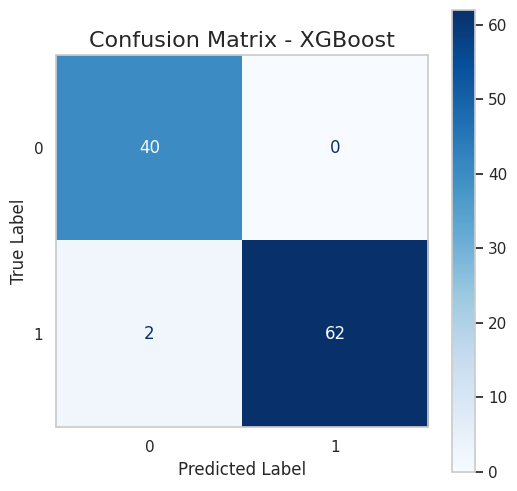

              precision    recall  f1-score   support

           0       0.95      1.00      0.98        40
           1       1.00      0.97      0.98        64

    accuracy                           0.98       104
   macro avg       0.98      0.98      0.98       104
weighted avg       0.98      0.98      0.98       104



In [25]:
# 3. Predict and Evaluate
y_pred_xgb = xgb.predict(X_test)

from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Confusion Matrix
cm_xgb = confusion_matrix(y_test, y_pred_xgb)

fig, ax = plt.subplots(figsize=(6, 6))
disp = ConfusionMatrixDisplay(confusion_matrix=cm_xgb, display_labels=xgb.classes_)
disp.plot(
    cmap="Blues",
    colorbar=True,
    ax=ax,
    values_format='d'
)
plt.title("Confusion Matrix - XGBoost", fontsize=16)
plt.xlabel("Predicted Label", fontsize=12)
plt.ylabel("True Label", fontsize=12)
plt.grid(False)
plt.show()

# Classification Report
print(classification_report(y_test, y_pred_xgb))


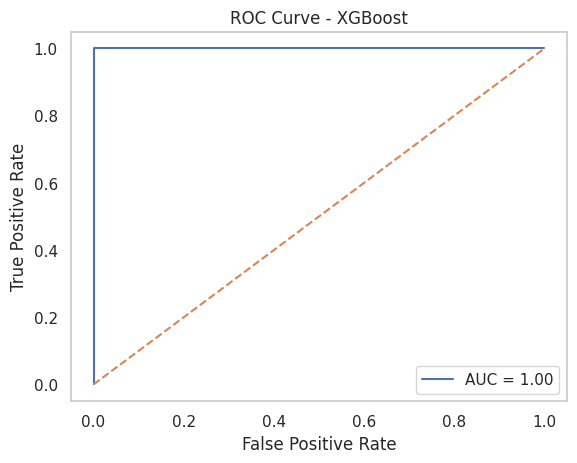

In [26]:
#4. ROC Curve
from sklearn.metrics import roc_auc_score, roc_curve

y_proba_xgb = xgb.predict_proba(X_test)[:,1]

fpr, tpr, thresholds = roc_curve(y_test, y_proba_xgb)
plt.plot(fpr, tpr, label=f"AUC = {roc_auc_score(y_test, y_proba_xgb):.2f}")
plt.plot([0,1], [0,1], linestyle='--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve - XGBoost")
plt.legend()
plt.grid()
plt.show()


In [27]:
#5. Cross Validation for XGBoost
from sklearn.model_selection import cross_val_score

scores_xgb = cross_val_score(xgb, X, y, cv=5, scoring='accuracy')
print(f"XGBoost Cross-validated accuracy: {scores_xgb.mean():.2f} ± {scores_xgb.std():.2f}")


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [13:29:02] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [13:29:02] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [13:29:02] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


XGBoost Cross-validated accuracy: 0.97 ± 0.03


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [13:29:02] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [13:29:02] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


In [28]:
#6.XGBoost Confidence Interval
# For XGBoost CV scores
mean_xgb = scores_xgb.mean()
std_xgb = scores_xgb.std()
conf_interval_xgb = stats.norm.interval(0.95, loc=mean_xgb, scale=std_xgb/np.sqrt(len(scores_xgb)))

print(f"XGBoost 95% Confidence Interval for Accuracy: {conf_interval_xgb}")


XGBoost 95% Confidence Interval for Accuracy: (np.float64(0.9398160576695448), np.float64(0.9947993269458398))


# 📈 XGBoost 95% Confidence Interval

I also calculated the **95% confidence interval** for XGBoost’s cross-validated accuracy to better understand how consistent the model is across different folds.

The result:
> **Accuracy is expected to fall between approximately 93.98% and 99.48% in 95% of random samples.**

This means:
- XGBoost performs **very reliably**, though its interval is slightly wider than Random Forest's.
- There's still **high confidence** that the model performs near 97–98% accuracy on unseen data.
- The lower bound (93.98%) is still strong, but this slight variation reinforces that **Random Forest had more stable performance overall**.

✅ In summary, XGBoost is an excellent model, but slightly less consistent than Random Forest in this particular dataset.


📈 Results:
- **Accuracy**: 98%
- **Recall**: 97%
- **AUC**: 1.00
- **Cross-Validation Accuracy**: 0.97 ± 0.03

XGBoost was also excellent, but slightly missed 2 diabetic cases compared to Random Forest’s 1 miss.

Still, it's impressive how all three models performed well.

# 📊 Final Model Comparison

Here’s a clear table summarizing everything:

| Metric              | Logistic Regression | Random Forest      | XGBoost           |
|---------------------|---------------------|--------------------|-------------------|
| Accuracy            | 93%                 | **99%**            | 98%               |
| Precision (Class 1) | 98%                 | **100%**           | **100%**          |
| Recall (Class 1)    | 91%                 | **98%**            | 97%               |
| F1-Score            | 94%                 | **99%**            | 98%               |
| ROC AUC             | 0.99                | **1.00**           | **1.00**          |
| False Positives     | 1                   | **0**              | **0**             |
| False Negatives     | 6                   | **1**              | 2                 |
| CV Accuracy         | —                   | **0.98 ± 0.03**     | 0.97 ± 0.03       |


# ✅ Final Model Selection

Although all models did well, I chose **Random Forest** as my final model.

Why?
- Highest **recall** (important for healthcare — missing diabetics can be dangerous).
- Perfect **precision** (no false alarms).
- Super consistent results during **cross-validation**.

If I were deploying this in a real hospital setting, I'd rather **catch as many true diabetics as possible**, even if it means slightly over-predicting — Random Forest allows that.


# 🧠 Precision-Recall Trade-Off

In healthcare applications, **recall** is often prioritized over precision.

This is because:
- Missing a diabetic patient (false negative) can lead to delayed treatment and serious health risks.
- In contrast, a false positive (incorrectly predicting someone has diabetes) would likely just lead to further testing.

Thus, among all models, I prioritized choosing the one with the **highest recall** while maintaining high precision — which in this case was the **Random Forest** model with a recall of 98% and precision of 100%.


# 💡 Feature Importance

Random Forest also let me see which symptoms were most predictive:

1. **Polyuria** (frequent urination)
2. **Polydipsia** (excessive thirst)
3. **Gender** (males slightly higher risk in this dataset)
4. **Age**
5. **Sudden Weight Loss**

✅ These top features make medical sense — real validation that the model is learning meaningful patterns!


# 🚀 Next Steps

Now that I have a solid model, here are some ideas for future work:

- Build a simple **Streamlit app** so users can input symptoms and get predictions.
- Use **SHAP** explainability tools to make model decisions more transparent.
- Expand to **external datasets** to check if the model generalizes outside this sample.

*Real data science is never really “finished” — there's always room to explore further.*


# 🧠 What I Learned

Reflecting on this project:

- Building the whole pipeline (EDA → preprocessing → modeling → evaluation) helped me appreciate every part of a data project.
- Comparing multiple models made me think critically, not just accept the first "good result."
- Even simple symptom checklists can power meaningful machine learning models that can help real people.

I'm excited to keep growing, learning, and tackling more real-world challenges with data!


In [31]:
#Save models as files

import joblib

# Save Logistic Regression model
joblib.dump(logreg, "diabetes_model_logistic.pkl")

# Save Random Forest model
joblib.dump(rf, "diabetes_model_rf.pkl")

# Save XGBoost model
joblib.dump(xgb, "diabetes_model_xgb.pkl")

# Save the feature names (same for both models)
feature_names = list(X.columns)
joblib.dump(feature_names, "feature_names.pkl")

['feature_names.pkl']

In [32]:
from google.colab import files

# Download Logistic Regression model
files.download('diabetes_model_logistic.pkl')

# Download Random Forest model
files.download('diabetes_model_rf.pkl')

# Download XGBoost model
files.download('diabetes_model_xgb.pkl')

# Download feature names
files.download('feature_names.pkl')


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>